USEFUL LINKS FOR DATA CLEANING:

https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?utm_source=blog&utm_medium=stockmarketpredictionarticle

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
import pandas as pd
import calendar as cd
import numpy as np
import os

DIRTY_FILE_NAME = 'ES=F.csv'
CLEAN_FILE_NAME = '(Clean)dowjones_stocks.csv'

## DATA EXTRACTION AND CLEANING AND FORMATTING
### Data Extraction
Putting the dow jones csv data into a dataframe

In [2]:
if os.path.exists(DIRTY_FILE_NAME):
    dowjones_stocks = pd.read_csv(DIRTY_FILE_NAME)
    print(dowjones_stocks.head())
else:
    print("Error: Input file not found")

         Date     Open     High      Low   Close  Adj Close    Volume
0  2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
1  2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2  2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
3  2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
4  2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


### Data Cleaning

The Dow Jones stock price dataset contains a number of null records typically during holidays or weekends, which are days when the stock market is closed. To clean this dataset, we will simply remove all null records. Due to the missing dates, it should be noted that the stock price forecasting model will not predict stock prices for each subsequent days. Rather, we should assume that the forecasting model will predict stock prices for the next subsequent day in which the stock price would typically be observed and recorded.

In [3]:
dowjones_stocks_cleaned = dowjones_stocks.loc[dowjones_stocks["Open"].isnull() == False]
dowjones_stocks

Date     Open     High      Low    Close  Adj Close     Volume
0     2000-09-18  1485.25  1489.75  1462.25  1467.50    1467.50   104794.0
1     2000-09-19  1467.00  1482.75  1466.75  1478.50    1478.50   103371.0
2     2000-09-20  1478.75  1480.50  1450.25  1469.50    1469.50   109667.0
3     2000-09-21  1470.25  1474.00  1455.50  1469.50    1469.50    98528.0
4     2000-09-22  1454.75  1471.00  1436.75  1468.50    1468.50    97416.0
...          ...      ...      ...      ...      ...        ...        ...
6190  2020-11-17  3625.50  3630.00  3584.25  3606.75    3606.75  1268206.0
6191  2020-11-18  3604.50  3623.25  3556.50  3565.00    3565.00  1325309.0
6192  2020-11-19  3562.00  3582.75  3542.25  3580.00    3580.00  1291117.0
6193  2020-11-20  3560.00  3582.50  3542.75  3554.25    3554.25  1189621.0
6194  2020-11-22      NaN      NaN      NaN      NaN        NaN        NaN

[6195 rows x 7 columns]

Check if there are any null values left in the dataset. There are none left.

In [4]:
dowjones_stocks_cleaned.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
#save cleaned data without the index column.
dowjones_stocks_cleaned.to_csv(CLEAN_FILE_NAME, index=0)

## BREAK POINT 1: Data Cleaned and saved till here. Can begin from here if saved file is available

In [6]:
if os.path.exists(CLEAN_FILE_NAME):
    dowjones_stocks_cleaned = pd.read_csv(CLEAN_FILE_NAME,index_col=['Date'])
    print(dowjones_stocks_cleaned.head())
else:
    print("Error: Clean File not found. Restart from the beginning")

               Open     High      Low   Close  Adj Close    Volume
Date                                                              
2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


# Model: CNN

We have 10 years work of data. Will use 9 years of data to predict the last year.
Will break the data down into weekly data and then use that to predict the daily high for each daya for a week.

In [7]:
def split(dataset):
    dataset = dataset.values
    length = len(dowjones_stocks_cleaned)
    print("Length=",length)
    total_weeks = int(length/5)
    print("Total Weeks=",total_weeks)
    
    #use last 1 year as test data set, everything else as train dataset
    WEEKS_IN_ONE_YEAR = 52
    ONE_YEAR_WORK_DAYS = 5*52
    
    train = dataset[0:-ONE_YEAR_WORK_DAYS]
    test = dataset[-ONE_YEAR_WORK_DAYS:]
    
    #convert to array
    train = np.array(train)
    test = np.array(test)
    
    print("-----TRAIN DATA-----")
    print("Length=",len(train))
    print("-----TEST DATA-----")
    print("Length=",len(test))
    print(test[0])
    return train,test
    
train_data,test_data = split(dowjones_stocks_cleaned)

Length= 5131
Total Weeks= 1026
-----TRAIN DATA-----
Length= 4871
-----TEST DATA-----
Length= 260
[   3237.      3261.75    3234.25    3259.      3259.   1416241.  ]


### What to predict?
Use the available data: Open Price, High, Low, Close, Adj Close, Volume to predict the High of next 1 week

In [8]:
COLUMN_TO_PREDICT = 3 #Closing cost for the day
NUMBER_OF_DAYS_DATA_TO_USE = 15
NUMBER_OF_COLUMNS = train_data.shape[1]
NUMBER_OF_DAYS_DATA_TO_PREDICT = 5

#split the given data into inputs and outputs. We can use last 7 days data to predict the next day 
# or we can use monthly data to predict. It depends onm how we want to model the data
# and will experiment with various models
#if column_with_result is None, then trying to make data for validation
def convert_data_into_io(input_data, steps, column_with_result, num_of_days_to_predict):
    print(column_with_result)
    x,y = list(), list()
    
    for i in range(len(input_data)):
        end = i + steps
        if end+1 > len(input_data) or end+num_of_days_to_predict > len(input_data):
            break
        
        _x = input_data[i:end,]
        _y = input_data[end:end+num_of_days_to_predict,column_with_result]
        
        y.append(_y)
        x.append(_x)
        
    return np.array(x), np.array(y)

In [9]:
train_x,train_y = convert_data_into_io(train_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Train Data:", len(train_x))
print("Sample Train Input Data:")
print(train_x[0])
print("Sample Train Output Data:")
print(train_y[0])
print("------------------------")

test_x,test_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Test Data:", len(test_x))
print("Sample Test Input Data:")
print(test_x[0])
print("Sample Test Output Data:")
print(test_y[0])
print("-------------------------")

3
------------------------
Total Train Data: 4852
Sample Train Input Data:
[[  1485.25   1489.75   1462.25   1467.5    1467.5  104794.  ]
 [  1467.     1482.75   1466.75   1478.5    1478.5  103371.  ]
 [  1478.75   1480.5    1450.25   1469.5    1469.5  109667.  ]
 [  1470.25   1474.     1455.5    1469.5    1469.5   98528.  ]
 [  1454.75   1471.     1436.75   1468.5    1468.5   97416.  ]
 [  1469.5    1477.75   1455.5    1461.     1461.    85491.  ]
 [  1461.     1467.     1442.5    1443.     1443.    99803.  ]
 [  1444.     1456.     1438.25   1446.75   1446.75 101996.  ]
 [  1447.75   1481.     1445.     1476.     1476.    84280.  ]
 [  1473.     1473.25   1454.     1454.     1454.    78277.  ]
 [  1453.75   1464.25   1447.5    1456.25   1456.25  84100.  ]
 [  1457.25   1474.     1438.75   1441.5    1441.5   89440.  ]
 [  1442.     1457.25   1432.5    1450.25   1450.25 101607.  ]
 [  1449.5    1462.     1447.25   1456.     1456.    92232.  ]
 [  1456.     1460.5    1411.5    1426.25  

In [20]:
from keras.layers import Dense
from keras import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Flatten
from keras.callbacks import Callback

EPOCHS=2000

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('.',end='')
    if epoch % 1000 == 0: print(': ',epoch)
        
# define model
def model_and_fit(x,y, modelFile, optimizer='adam'):
    if os.path.exists(modelFile):
        #delete file
        os.rmdir(modelFile)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(NUMBER_OF_DAYS_DATA_TO_USE, NUMBER_OF_COLUMNS)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(NUMBER_OF_DAYS_DATA_TO_PREDICT)) #5 days of data
    model.compile(optimizer=optimizer, loss='mae')
    model.fit(x,y, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])
    #save model
    model.save(modelFile)
    print("Model fitted and saved!")
    return model


In [11]:
#SAVE MODEL AFTER FITTING. If saved model is available, then reload that
from keras.models import load_model
optimizer = 'adam'
SAVED_MODEL_NAME = "CNN_ModelSaved"+optimizer
model = None

if os.path.exists(SAVED_MODEL_NAME):
    print("Model Found: Loading...")
    model = load_model(SAVED_MODEL_NAME)
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model = model_and_fit(train_x,train_y,SAVED_MODEL_NAME,optimizer)
    

Model not Found. Fitting model...
.:  0
....................................................................................................:  1000
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN_ModelSavedadam\assets
Model fitted and saved!


In [12]:
#function for preditions and error calculating
def predict(model, input_data):
    input_data = input_data.reshape(1,NUMBER_OF_DAYS_DATA_TO_USE,NUMBER_OF_COLUMNS)
    value = model.predict(input_data, verbose=0)
    return value[0]


def check_all_test_data(data, model):
    predicted_data = []
    i = 1
    for d in data:
        print('.',end='')
        if i%20 == 0: print('-',i)
        d = d.reshape((1, NUMBER_OF_DAYS_DATA_TO_USE, NUMBER_OF_COLUMNS))
        data = predict(model,d)
        predicted_data.append(data)
        i = i+1
    print('-',i)
    return predicted_data

print("Start predicting data...")
predicted_y = check_all_test_data(test_x, model)
#convert predicted from list to araay
predicted_y = np.array(predicted_y)
print("End of data prediction!")

Start predicting data...
....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


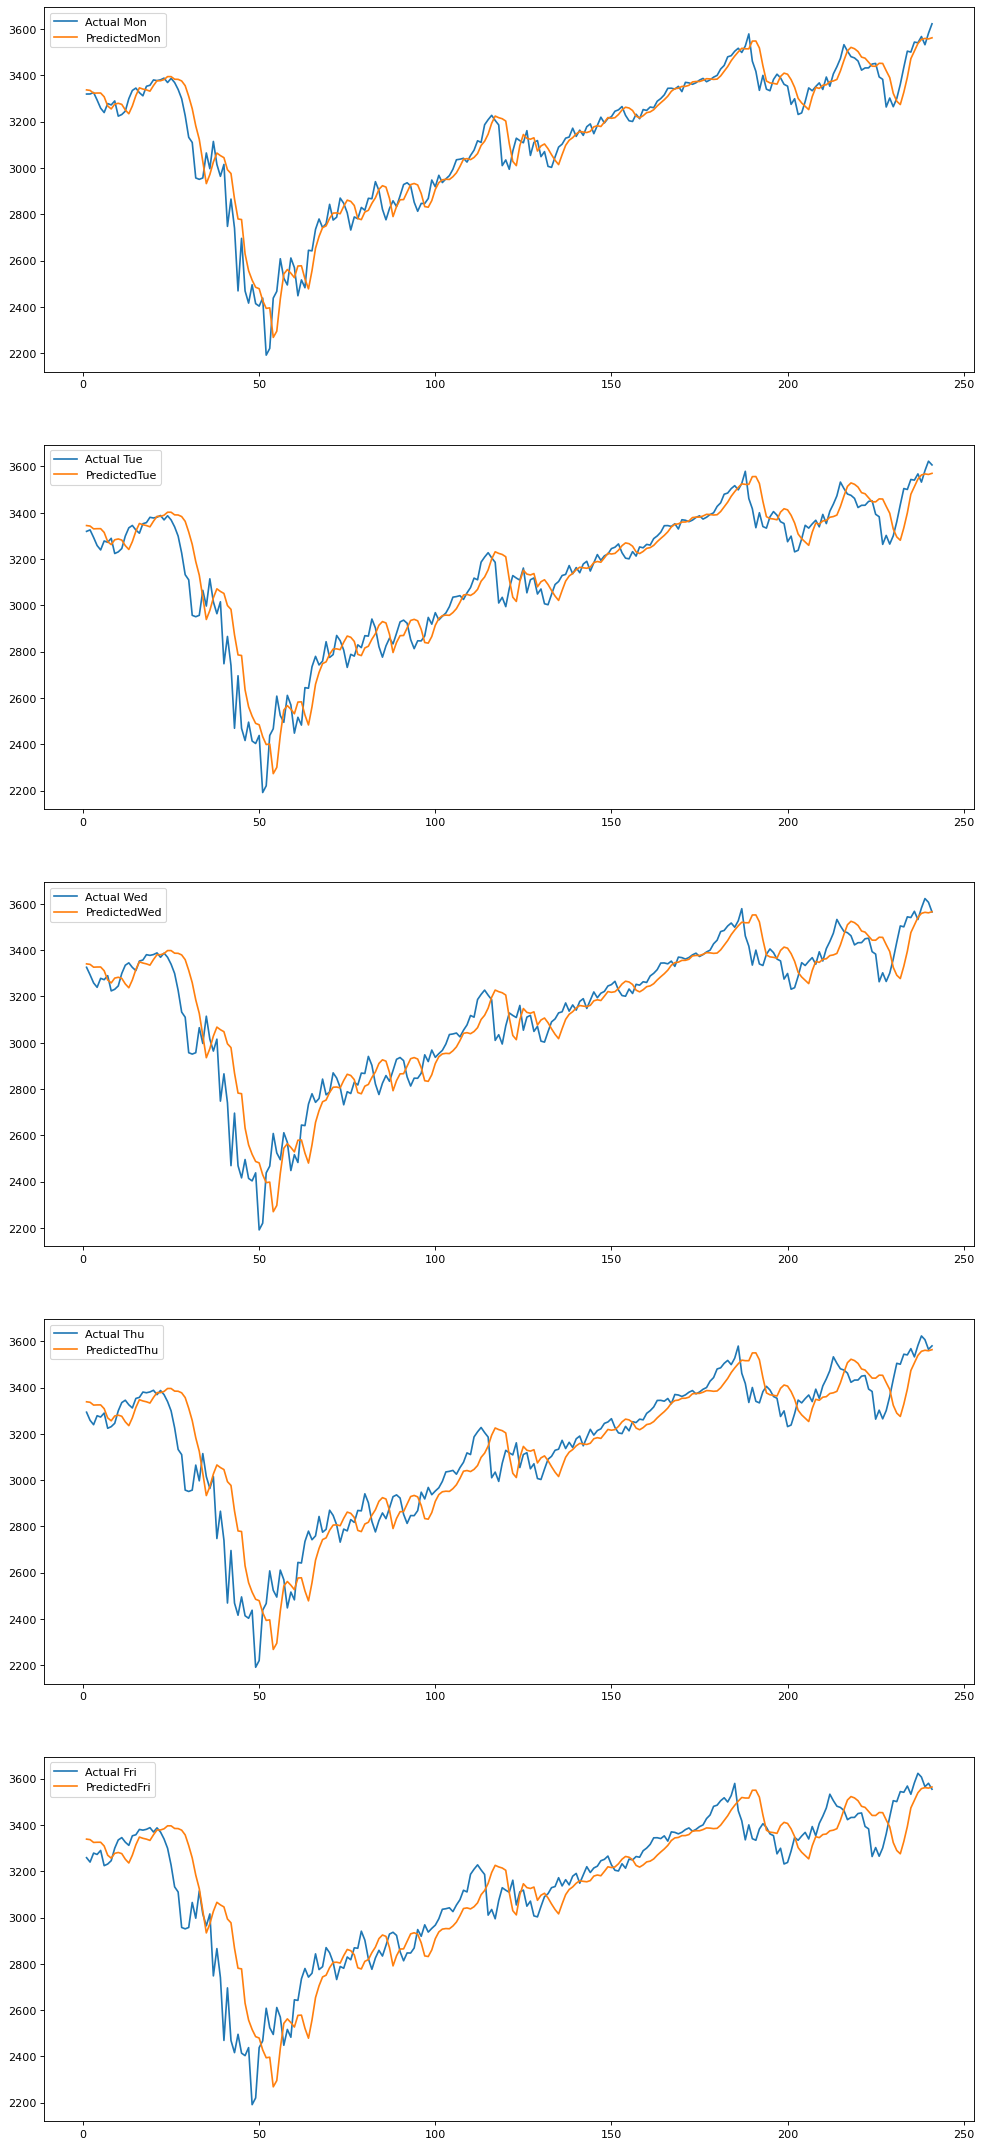

In [13]:
import math
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def get_single_rmse(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    return rmse

def get_rmse_list(actual_list, predicted_list):
    rmse = []
    sum_rmse = 0
    for i in range(0,len(actual_list)):
        _rmse = get_single_rmse(actual_list[i],predicted_list[i] )
        rmse.append(_rmse)
        sum_rmse = sum_rmse+_rmse
    average_rmse = sum_rmse / len(actual_list)
    return rmse, average_rmse

def percent_single_percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100


#get percent difference between actual and predicted
difference = []
for i in range(0,len(test_y)):
    difference.append(percent_single_percent_diff(test_y[i],predicted_y[i]))
difference = np.array(difference)   
    
rmse,avg_rmse = get_rmse_list(test_y, predicted_y)

x_axis = np.arange(1,len(test_y)+1)
Labels = ['Mon','Tue','Wed','Thu','Fri']

figure(num=None, figsize=(15, 35), dpi=80, facecolor='w', edgecolor='k')

for i in range(0,NUMBER_OF_DAYS_DATA_TO_PREDICT):
    #plt.subplot(5, 1, i+1)
    plt.subplot(5, 1, i+1)
    plt.plot(x_axis, test_y[:,i], label='Actual '+Labels[i])
    plt.plot(x_axis, predicted_y[:,i], label='Predicted'+Labels[i])
    plt.legend()
    

Average RMSE =  83.88986856651331


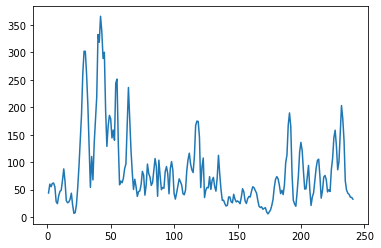

In [14]:
#plottign RMSE and average percent difference
print("Average RMSE = ", avg_rmse)
plt.plot(x_axis, rmse, label='Actual '+Labels[i])

Average percent difference in predicted value for different days:
Mon :  -0.37 %
Tue :  -0.58 %
Wed :  -0.45 %
Thu :  -0.36 %
Fri :  -0.36 %
Overall percent difference =  -0.42 %


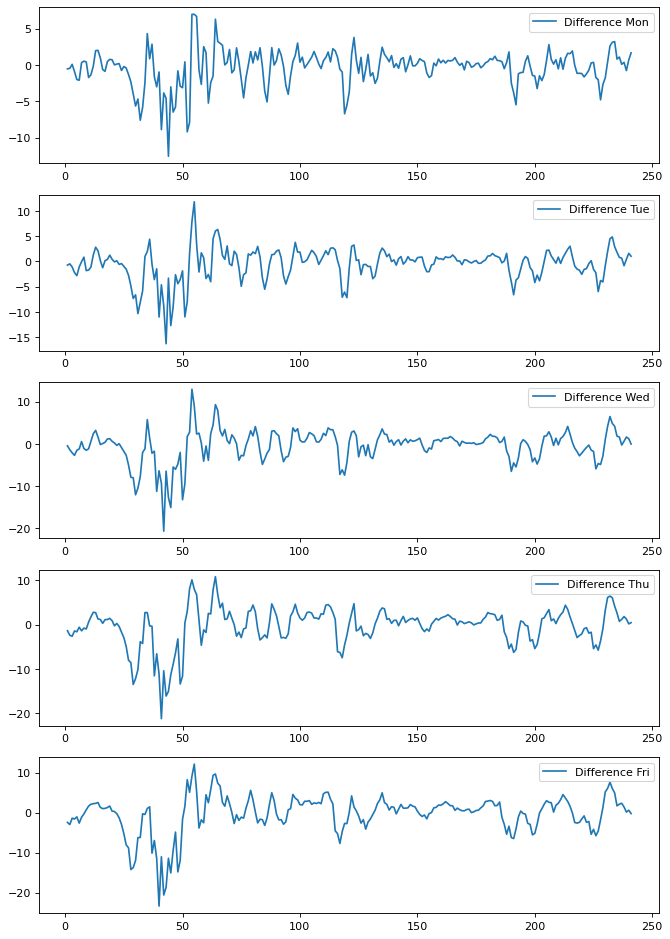

In [15]:
figure(num=None, figsize=(10, 15), dpi=80, facecolor='w', edgecolor='k')
_sum = 0
print("Average percent difference in predicted value for different days:")
for i in range(0,NUMBER_OF_DAYS_DATA_TO_PREDICT):
    average = np.average(difference[:,i])
    _sum = _sum + average
    print(Labels[i]+" : ", round(average,2),"%")
    
    plt.subplot(5, 1, i+1)
    plt.plot(x_axis, difference[:,i], label='Difference '+Labels[i])
    plt.legend()
    
    
print("Overall percent difference = ", round(_sum/NUMBER_OF_DAYS_DATA_TO_PREDICT,2), "%")

Model not Found. Fitting model...
.:  0
....................................................................................................:  1000
...................................................................................................INFO:tensorflow:Assets written to: CNN_ModelSavedRMSProp\assets
Model fitted and saved!
Optimizer = RMSProp
Start predicting data...
....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!
Average RMSE =  157.1453175212513
Average percent difference in predicted value for different days:
Mon :  3.83 %
Tue :  3.8 %
Wed :  3.6 %
Thu :  3.25 %
Fri :  3.37 %
Overall percent difference =  3.57 %


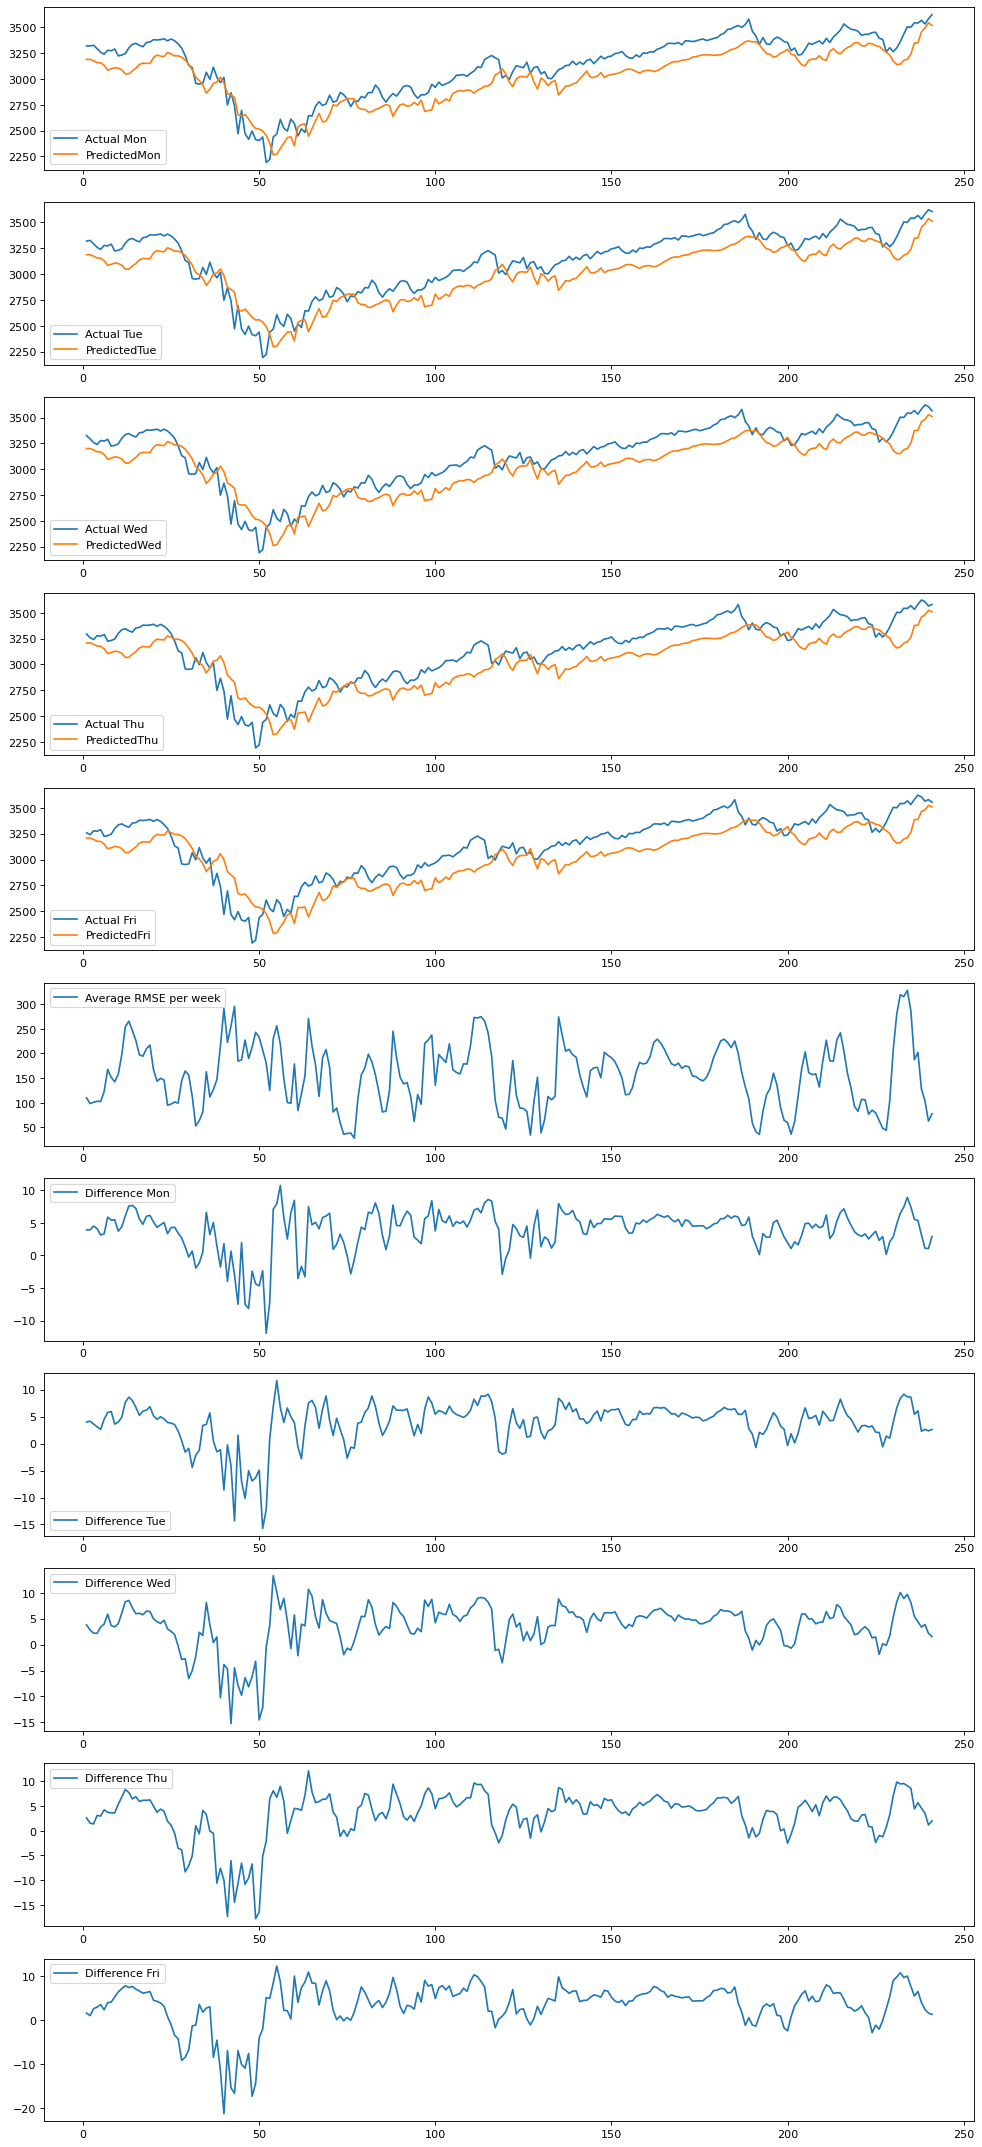

In [16]:
#using rmsprop instead of adam
optimizer = 'RMSProp'

SAVED_MODEL_NAME = "CNN_ModelSaved"+optimizer
model = None
if os.path.exists(SAVED_MODEL_NAME):
    print("Model Found: Loading...")
    model = load_model(SAVED_MODEL_NAME)
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model = model_and_fit(train_x,train_y,SAVED_MODEL_NAME,optimizer)

print("Optimizer = "+optimizer)
print("Start predicting data...")
predicted_y = check_all_test_data(test_x, model)
#convert predicted from list to araay
predicted_y = np.array(predicted_y)
print("End of data prediction!")

#get percent difference between actual and predicted
difference = []
for i in range(0,len(test_y)):
    difference.append(percent_single_percent_diff(test_y[i],predicted_y[i]))
difference = np.array(difference)   
    
rmse,avg_rmse = get_rmse_list(test_y, predicted_y)

x_axis = np.arange(1,len(test_y)+1)
Labels = ['Mon','Tue','Wed','Thu','Fri']

figure(num=None, figsize=(15, 35), dpi=80, facecolor='w', edgecolor='k')

for i in range(0,NUMBER_OF_DAYS_DATA_TO_PREDICT):
    #plt.subplot(5, 1, i+1)
    plt.subplot(11, 1, i+1)
    plt.plot(x_axis, test_y[:,i], label='Actual '+Labels[i])
    plt.plot(x_axis, predicted_y[:,i], label='Predicted'+Labels[i])
    plt.legend()

#plottign RMSE and average percent difference
print("Average RMSE = ", avg_rmse)
plt.subplot(11, 1, NUMBER_OF_DAYS_DATA_TO_PREDICT+1)
plt.plot(x_axis, rmse, label='Average RMSE per week')
plt.legend()


_sum = 0
print("Average percent difference in predicted value for different days:")
for i in range(0,NUMBER_OF_DAYS_DATA_TO_PREDICT):
    average = np.average(difference[:,i])
    _sum = _sum + average
    print(Labels[i]+" : ", round(average,2),"%")
    
    plt.subplot(11, 1, NUMBER_OF_DAYS_DATA_TO_PREDICT+1+i+1)
    plt.plot(x_axis, difference[:,i], label='Difference '+Labels[i])
    plt.legend()
    
print("Overall percent difference = ", round(_sum/NUMBER_OF_DAYS_DATA_TO_PREDICT,2), "%")


Model not Found. Fitting model...
.:  0
....................................................................................................:  1000
...................................................................................................INFO:tensorflow:Assets written to: CNN_ModelSavednadam\assets
Model fitted and saved!
Optimizer = nadam
Start predicting data...
....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!
Average RMSE =  90.32558314523554
Average percent difference in predicted value for different days:
Mon :  0.84 %
Tue :  0.8 %
Wed :  0.46 %
Thu :  0.38 %
Fri :  0.52 %
Overall percent difference =  0.6 %


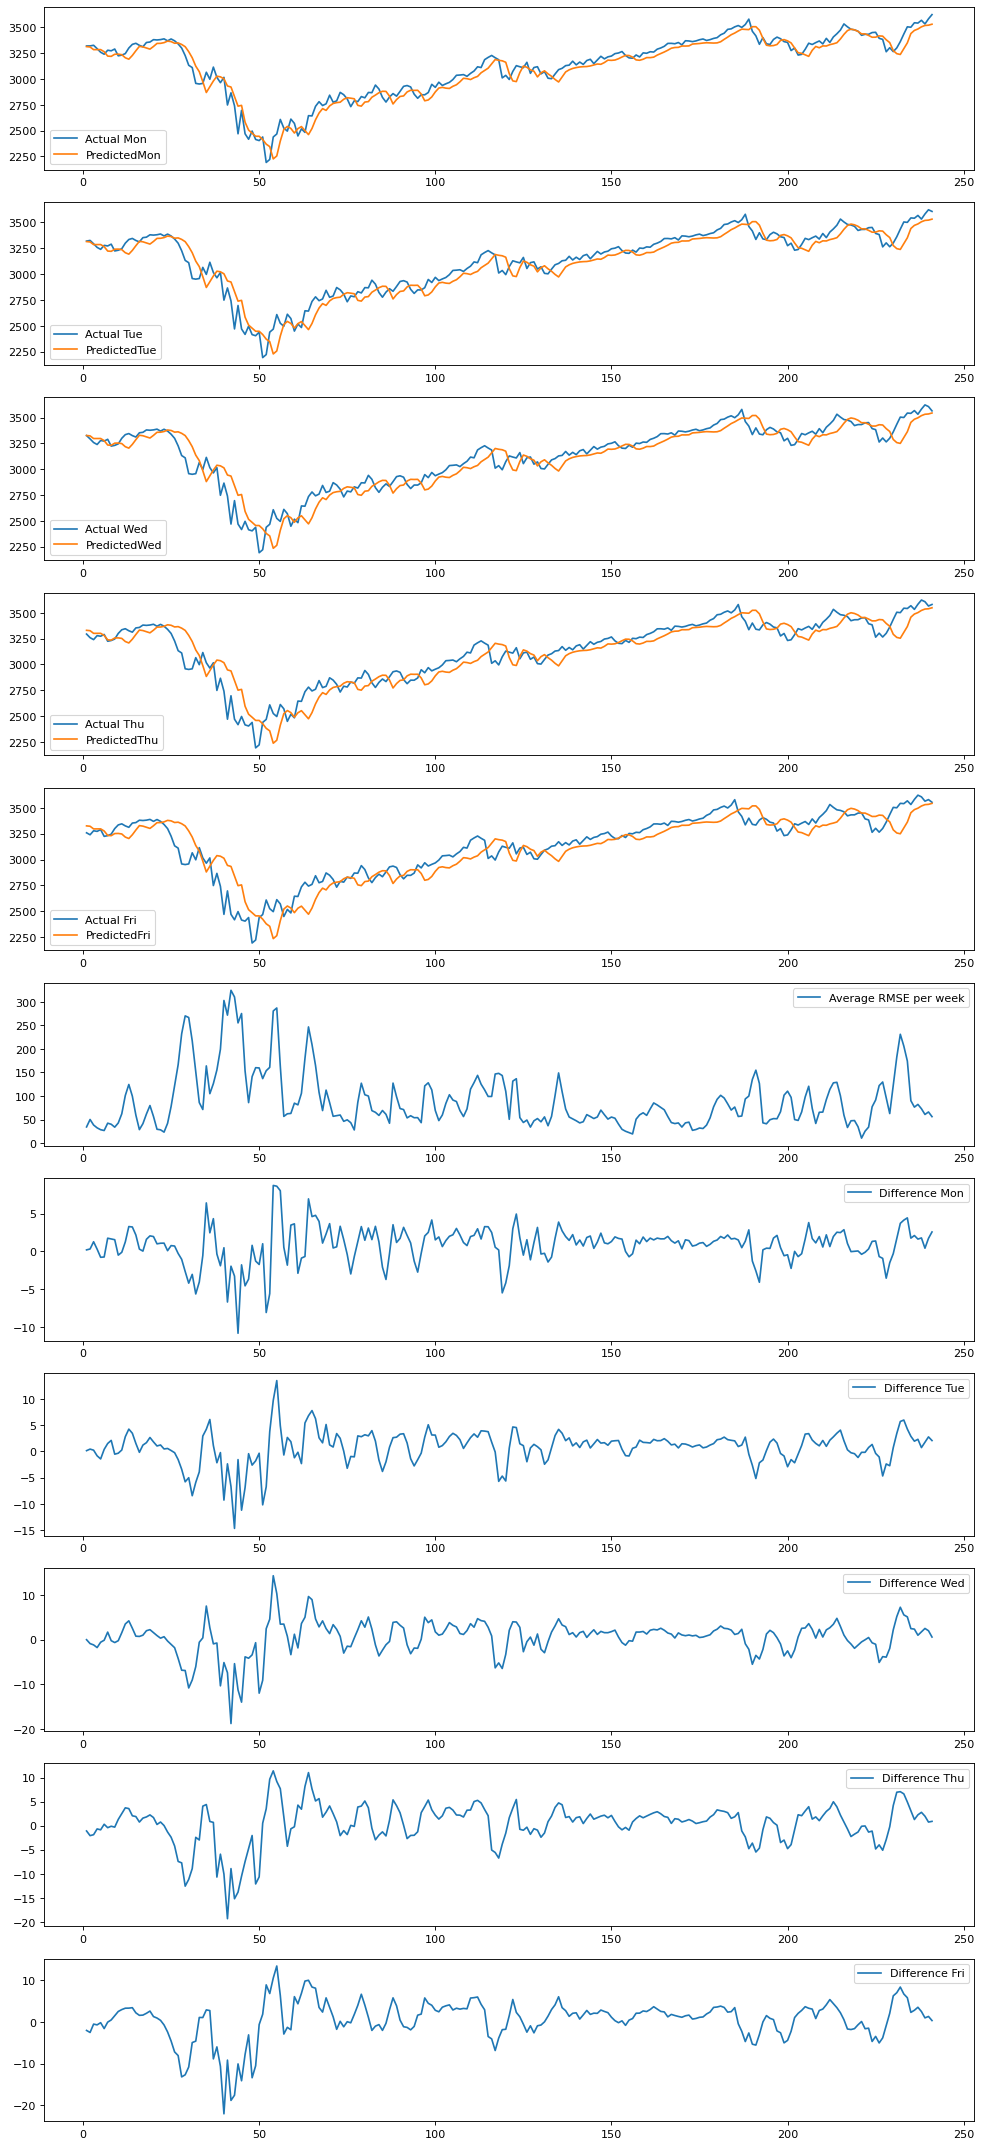

In [21]:
#using rmsprop instead of adam
optimizer = 'nadam'

SAVED_MODEL_NAME = "CNN_ModelSaved"+optimizer
model = None
if os.path.exists(SAVED_MODEL_NAME):
    print("Model Found: Loading...")
    model = load_model(SAVED_MODEL_NAME)
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model = model_and_fit(train_x,train_y,SAVED_MODEL_NAME,optimizer)

print("Optimizer = "+optimizer)
print("Start predicting data...")
predicted_y = check_all_test_data(test_x, model)
#convert predicted from list to araay
predicted_y = np.array(predicted_y)
print("End of data prediction!")

#get percent difference between actual and predicted
difference = []
for i in range(0,len(test_y)):
    difference.append(percent_single_percent_diff(test_y[i],predicted_y[i]))
difference = np.array(difference)   
    
rmse,avg_rmse = get_rmse_list(test_y, predicted_y)

x_axis = np.arange(1,len(test_y)+1)
Labels = ['Mon','Tue','Wed','Thu','Fri']

figure(num=None, figsize=(15, 35), dpi=80, facecolor='w', edgecolor='k')

for i in range(0,NUMBER_OF_DAYS_DATA_TO_PREDICT):
    #plt.subplot(5, 1, i+1)
    plt.subplot(11, 1, i+1)
    plt.plot(x_axis, test_y[:,i], label='Actual '+Labels[i])
    plt.plot(x_axis, predicted_y[:,i], label='Predicted'+Labels[i])
    plt.legend()

#plottign RMSE and average percent difference
print("Average RMSE = ", avg_rmse)
plt.subplot(11, 1, NUMBER_OF_DAYS_DATA_TO_PREDICT+1)
plt.plot(x_axis, rmse, label='Average RMSE per week')
plt.legend()


_sum = 0
print("Average percent difference in predicted value for different days:")
for i in range(0,NUMBER_OF_DAYS_DATA_TO_PREDICT):
    average = np.average(difference[:,i])
    _sum = _sum + average
    print(Labels[i]+" : ", round(average,2),"%")
    
    plt.subplot(11, 1, NUMBER_OF_DAYS_DATA_TO_PREDICT+1+i+1)
    plt.plot(x_axis, difference[:,i], label='Difference '+Labels[i])
    plt.legend()
    
print("Overall percent difference = ", round(_sum/NUMBER_OF_DAYS_DATA_TO_PREDICT,2), "%")